<a href="https://colab.research.google.com/github/kaysriram/MLZoomCamp2025/blob/main/DataTalksHW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importing Dataset

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-04 17:22:25--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.05s   

2025-10-04 17:22:25 (18.1 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [3]:
data=pd.read_csv('/content/car_fuel_efficiency.csv')
data.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
df=data[['engine_displacement',
'horsepower',
'vehicle_weight',
'model_year',
'fuel_efficiency_mpg']]
df.shape

(9704, 5)

EDA

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

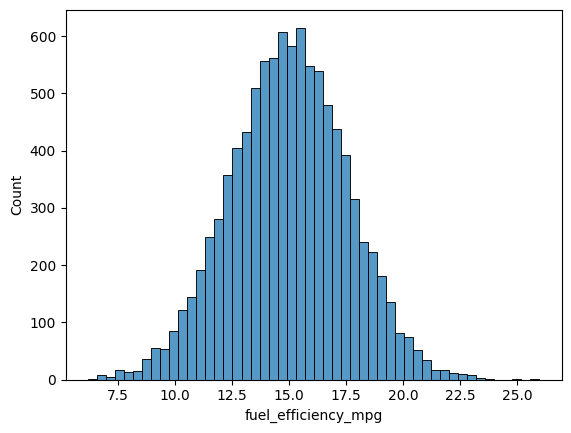

In [5]:
sns.histplot(df['fuel_efficiency_mpg'],bins=50)

Conclusion: It has a normal distribution

Q1. Missing values

In [6]:
df.isnull().any()

,0
engine_displacement,False
horsepower,True
vehicle_weight,False
model_year,False
fuel_efficiency_mpg,False


Horsepower has missing values

Q2. Median of horsepower

In [7]:
df['horsepower'].median()

149.0

Q3.

In [8]:
n=len(df)
n_val=int(n*0.2)
n_test=int(n*0.2)
n_train=n-n_val-n_test

np.random.seed(42)
idx=np.arange(n)
np.random.shuffle(idx)

df_shuffled=df.iloc[idx]

df_train= df_shuffled.iloc[:n_train].copy()
df_val= df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test= df_shuffled.iloc[n_train+n_val:].copy()

y_train=df_train.fuel_efficiency_mpg.values
y_val=df_val.fuel_efficiency_mpg.values
y_test=df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)








In [9]:
def prep0_X(d):
    d = d.copy()
    d['horsepower'] = d['horsepower'].fillna(0)
    return d.values

def lr(X,y):
  ones=np.ones(X.shape[0])
  X=np.column_stack([ones,X])

  XTX=X.T.dot(X)
  XTX_inv=np.linalg.inv(XTX)
  w= XTX_inv.dot(X.T).dot(y)
  return w[0],w[1:]


Case:1(When Filled with 0)



In [10]:
X_train=prep0_X(df_train)
w_0,w= lr(X_train,y_train)
y_pred0=w_0+X_train.dot(w)

In [11]:
y_pred0

array([17.33526223, 16.29296317, 17.69885099, ..., 17.54541307,
       18.78287539, 17.86564843])

Case 2: When filled with its mean

In [12]:
def prep1_X(d):
    d = d.copy()
    d['horsepower'] = d['horsepower'].fillna(d['horsepower'].mean())
    return d.values

In [13]:
X_train=prep1_X(df_train)
w0,w1=lr(X_train,y_train)
y_pred1=w0+X_train.dot(w1)

In [14]:
y_pred1

array([17.25910991, 16.19011261, 17.6924588 , ..., 17.51666431,
       18.77812427, 17.84593445])

RMSE Calculation

In [15]:
def rmse(y,y_pred):
  e=((y-y_pred)**2).mean()
  rmse=np.sqrt(e)
  return round(rmse,2)


Validation Set

In [16]:
#Imputation of 0 onto the horsepower column

X_val_0 = prep0_X(df_val)
y_pred0_val = w_0 + X_val_0.dot(w)

#Imputation of mean onto the horsepower column
X_val_1 = prep1_X(df_val)
y_pred1_val = w0 + X_val_1.dot(w1)

print(f'The RMSE of imputation with 0: {rmse(y_val,y_pred0_val)}')
print(f'The RMSE of imputation with mean: {rmse(y_val,y_pred1_val)}')

The RMSE of imputation with 0: 0.52
The RMSE of imputation with mean: 0.46


Conclusion: Imputation with mean better in this scenario


Q4. Best parameter


Regularized LR

In [17]:
#seed 42 is used above in splitting the dataset.So, we're good!
def lr_reg(X,y,r=0.1):
  ones=np.ones(X.shape[0])
  X=np.column_stack([ones,X])

  XTX=X.T.dot(X)
  reg=r*np.eye(XTX.shape[0])
  XTX+=reg
  XTX_inv=np.linalg.inv(XTX)
  w= XTX_inv.dot(X.T).dot(y)
  return w[0],w[1:]


In [18]:
def rmse_round6(y,y_pred):
  e=((y-y_pred)**2).mean()
  rmse=np.sqrt(e)
  return round(rmse,6)


In [19]:
X_train=prep0_X(df_train)
X_val_0 = prep0_X(df_val)
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
  w_0,w=lr_reg(X_train,y_train,r)
  y_pred0_val = w_0 + X_val_0.dot(w)
  print(f'The RMSE score for regularization parameter {r} is: {rmse_round6(y_pred0_val,y_val)}')


The RMSE score for regularization parameter 0 is: 0.517378
The RMSE score for regularization parameter 0.01 is: 0.517112
The RMSE score for regularization parameter 0.1 is: 0.518753
The RMSE score for regularization parameter 1 is: 0.522235
The RMSE score for regularization parameter 5 is: 0.522892
The RMSE score for regularization parameter 10 is: 0.522981
The RMSE score for regularization parameter 100 is: 0.523064


Best parameter i.e lowest RMSE score: r=0.01

Q5. Changing seed values

In [20]:
rmse_score=[]
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
  np.random.seed(i)
  idx=np.arange(n)
  np.random.shuffle(idx)

  df_shuffled=df.iloc[idx]

  df_train= df_shuffled.iloc[:n_train].copy()
  df_val= df_shuffled.iloc[n_train:n_train+n_val].copy()
  df_test= df_shuffled.iloc[n_train+n_val:].copy()

  y_train=df_train.fuel_efficiency_mpg.values
  y_val=df_val.fuel_efficiency_mpg.values
  y_test=df_test.fuel_efficiency_mpg.values

  del df_train['fuel_efficiency_mpg']
  del df_val['fuel_efficiency_mpg']
  del df_test['fuel_efficiency_mpg']

  df_train=df_train.reset_index(drop=True)
  df_val=df_val.reset_index(drop=True)
  df_test=df_test.reset_index(drop=True)

  X_train=prep0_X(df_train)
  X_val=prep0_X(df_val)

  w_0,w=lr(X_train,y_train)
  y_pred0_val = w_0 + X_val.dot(w)
  rmse_score.append(rmse_round6(y_val,y_pred0_val))

print(rmse_score)


[np.float64(0.520653), np.float64(0.521339), np.float64(0.522807), np.float64(0.515952), np.float64(0.510913), np.float64(0.528341), np.float64(0.531391), np.float64(0.509067), np.float64(0.51474), np.float64(0.513187)]


In [21]:
np.std(rmse_score)

np.float64(0.006989431035499233)

Q6. Evaluation on Test

In [22]:
np.random.seed(9)
idx=np.arange(n)
np.random.shuffle(idx)

df_shuffled=df.iloc[idx]

df_train= df_shuffled.iloc[:n_train].copy()
df_val= df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test= df_shuffled.iloc[n_train+n_val:].copy()

y_train=df_train.fuel_efficiency_mpg.values
y_val=df_val.fuel_efficiency_mpg.values
y_test=df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

In [23]:
X_train=prep0_X(df_train)
X_val=prep0_X(df_val)
w_0,w=lr_reg(X_train,y_train,0.001)
y_pred=w_0+ X_val.dot(w)
rmse_round6(y_val,y_pred)

np.float64(0.513179)